In [1]:
import numpy as np
from collections import deque
from numpy.polynomial import polynomial as P
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm, t
from math import *
from sklearn.isotonic import IsotonicRegression
np.random.seed(42)

In [13]:
class Peak_Valley_Simu():
    def __init__(self):
        self.x = None
        self.y = None
        self.n = None
        self.left_dot_num = None
        self.right_dot_num = None
        self.left_start_index, self.left_end_index = None, None
        self.right_start_index, self.right_end_index = None, None
        self.intercept = None
    
    def generate_data(self, n, region, intercept, left_slope, right_slope, error_term):
        self.n = n
        self.x = np.linspace(-region, region, 2*n)
        y_left = intercept + left_slope*self.x[:n] + error_term*np.random.randn(n)
        y_right = intercept + right_slope*self.x[n:] + error_term*np.random.randn(n)
        self.y = np.hstack((y_left, y_right))
        self.beta_left = left_slope
        self.beta_right = right_slope
    
    def auto_peakzone_detection(self, x_coordinate, initial_range=0.01, iter_scale=1, maxiter=100, estimation_mode=False, quote=False):
        '''
            quote:是否有被其他方法使用到0
        '''
        count = 0
        fit_range = initial_range

        while count < maxiter:
            self.left_start_index = np.min(np.where(self.x > x_coordinate-fit_range)[0])
            self.left_end_index = np.max(np.where(self.x < x_coordinate)[0])
            self.right_start_index = np.min(np.where(self.x > x_coordinate)[0])
            self.right_end_index = np.max(np.where(self.x < x_coordinate+fit_range)[0])
            
            X = sm.add_constant(self.x)

            self.left_dot_num = self.left_end_index-self.left_start_index+1
            self.right_dot_num = self.right_end_index-self.right_start_index+1

            mod_left = sm.OLS(self.y[self.left_start_index:self.left_end_index+1],
                              X[self.left_start_index:self.left_end_index+1])
            res_left = mod_left.fit()
            mod_right = sm.OLS(self.y[self.right_start_index:self.right_end_index+1],
                               X[self.right_start_index:self.right_end_index+1])
            res_right = mod_right.fit()

            left_Sxx = res_left.ess / (res_left.params[1])**2
            right_Sxx = res_right.ess / (res_right.params[1])**2

            if not estimation_mode: # 利用已知當初所設的資料斜率
                z_left = -t.ppf(0.05, df=self.left_dot_num-2) - self.beta_left / sqrt(res_left.mse_resid/left_Sxx)
                z_right = t.ppf(0.05, df=self.right_dot_num-2) - self.beta_right / sqrt(res_right.mse_resid/right_Sxx)
            if estimation_mode:
                z_left = -t.ppf(0.05, df=self.left_dot_num-2) - res_left.params[1] / sqrt(res_left.mse_resid/left_Sxx)
                z_right = t.ppf(0.05, df=self.right_dot_num-2) - res_right.params[1] / sqrt(res_right.mse_resid/right_Sxx)
            
            if ((1-norm.cdf(z_left) >= sqrt(0.9)) and (norm.cdf(z_right) >= sqrt(0.9)) and (res_left.pvalues[1]+res_right.pvalues[1])/2 <= 0.05):
                break
            
            # if (res_left.pvalues[1]+res_right.pvalues[1])/2 <= 0.05:
            #     break

            fit_range += iter_scale*initial_range
            count += 1

        if (count == maxiter and quote):
            return False
            # return {"fitting range":round(fit_range, 5), "iteration number":count,
            #         "left regression":res_left, "right regression":res_right,
            #         "z_left":z_left, "z_right":z_right,
            #         "left_Sxx":left_Sxx, "right_Sxx":right_Sxx}
        
        return {"fitting range":round(fit_range, 5), "iteration number":count,
                "left regression":res_left, "right regression":res_right,
                "z_left":z_left, "z_right":z_right,
                "left_Sxx":left_Sxx, "right_Sxx":right_Sxx}
                # "left index":[i for i in range(left_start_index, left_end_index+1)], "right index":[j for j in range(right_start_index, right_end_index+1)]
    
    def auto_valleyzone_detection(self, x_coordinate, initial_range=0.01, iter_scale=1, maxiter=100, estimation_mode=False, quote=False):
        count = 0
        fit_range = initial_range
        while count < maxiter:

            left_start_index = np.min(np.where(self.x > x_coordinate-fit_range)[0])
            left_end_index = np.max(np.where(self.x < x_coordinate)[0])
            right_start_index = np.min(np.where(self.x > x_coordinate)[0])
            right_end_index = np.max(np.where(self.x < x_coordinate+fit_range)[0])
            X = sm.add_constant(self.x)
            self.left_dot_num = left_end_index-left_start_index+1
            self.right_dot_num = right_end_index-right_start_index+1

            mod_left = sm.OLS(self.y[left_start_index:left_end_index+1],
                              X[left_start_index:left_end_index+1])
            res_left = mod_left.fit()
            mod_right = sm.OLS(self.y[right_start_index:right_end_index+1],
                               X[right_start_index:right_end_index+1])
            res_right = mod_right.fit()

            left_Sxx = res_left.ess / (res_left.params[1])**2
            right_Sxx = res_right.ess / (res_right.params[1])**2

            if not estimation_mode:
                z_left = t.ppf(0.05, df=self.left_dot_num-2) - self.beta_left / sqrt(res_left.mse_resid/left_Sxx)
                z_right = -t.ppf(0.05, df=self.right_dot_num-2) - self.beta_right / sqrt(res_right.mse_resid/right_Sxx)
            if estimation_mode:
                z_left = t.ppf(0.05, df=self.left_dot_num-2) - res_left.params[1] / sqrt(res_left.mse_resid/left_Sxx)
                z_right = -t.ppf(0.05, df=self.right_dot_num-2) - res_right.params[1] / sqrt(res_right.mse_resid/right_Sxx)

            if ((norm.cdf(z_left) >= sqrt(0.9)) and (1-norm.cdf(z_right) >= sqrt(0.9)) and (res_left.pvalues[1]+res_right.pvalues[1])/2 <= 0.05):
                break

            fit_range += iter_scale*initial_range
            count += 1
        
        if (count == maxiter and quote):
            return False

        return {"fitting range":round(fit_range, 5), "iteration number":count,
                "left regression":res_left, "right regression":res_right,
                "z_left":z_left, "z_right":z_right,
                "left_Sxx":left_Sxx, "right_Sxx":right_Sxx}

    def scatter_peakreg_plot(self, x_coordinate, estimation_mode):
        plt.figure(figsize=(16, 9), dpi=200)
        plt.grid()
        plt.scatter(self.x, self.y)
        plt.plot(self.x[self.left_start_index:self.left_end_index+1], # self.n-self.left_dot_num+1:self.n+1
                 self.auto_peakzone_detection(x_coordinate, estimation_mode=estimation_mode)["left regression"].predict(),
                 "r")
        plt.plot(self.x[self.right_start_index:self.right_end_index+1], # self.n+1:self.n+self.right_dot_num+1
                 self.auto_peakzone_detection(x_coordinate, estimation_mode=estimation_mode)["right regression"].predict(),
                 "k")
                 
    def scatter_valleyreg_plot(self, x_coordinate):
        plt.figure(figsize=(16, 9))
        plt.grid()
        plt.scatter(self.x, self.y)
        plt.plot(self.x[self.left_start_index:self.left_end_index+1],
                 self.auto_valleyzone_detection(x_coordinate)["left regression"].predict(),
                 "r")
        plt.plot(self.x[self.right_start_index:self.right_end_index+1],
                 self.auto_valleyzone_detection(x_coordinate)["right regression"].predict(),
                 "k")

    def simu_probability(self, left_slope, right_slope, condition="peak"):
        fitting_range_list = []
        left_dot_num_list, right_dot_num_list = [], []
        left_betahat_list, right_betahat_list = [], []
        leftsigma_hat_list, rightsigma_hat_list = [], []
        left_Sxx, right_Sxx = [], []

        for i in range(1000):
            np.random.seed(i)
            self.generate_data(500, 1, 0, left_slope=left_slope, right_slope=right_slope, error_term=0.3)
            apd = self.auto_peakzone_detection(0)
            
            fitting_range_list.append(apd["fitting range"])
            left_dot_num_list.append(self.left_dot_num)
            right_dot_num_list.append(self.right_dot_num)
            left_betahat_list.append(apd["left regression"].params[1])
            right_betahat_list.append(apd["right regression"].params[1])
            leftsigma_hat_list.append(sqrt(apd["left regression"].mse_resid))
            rightsigma_hat_list.append(sqrt(apd["right regression"].mse_resid))
            left_Sxx.append(apd["left_Sxx"])
            right_Sxx.append(apd["right_Sxx"])

        fitting_range_list = np.array(fitting_range_list)
        left_dot_num_list = np.array(left_dot_num_list)
        right_dot_num_list = np.array(right_dot_num_list)
        left_betahat_list = np.array(left_betahat_list)
        right_betahat_list = np.array(right_betahat_list)
        leftsigma_hat_list = np.array(leftsigma_hat_list)
        rightsigma_hat_list = np.array(rightsigma_hat_list)
        left_Sxx = np.array(left_Sxx)
        right_Sxx = np.array(right_Sxx)

        # z_left = -t.ppf(0.05, df=self.left_dot_num-2) - beta_left / (np.mean(leftsigma_hat_list)/sqrt(left_Sxx))
        # z_right = t.ppf(0.05, df=self.right_dot_num-2) - beta_right / (np.mean(rightsigma_hat_list)/sqrt(right_Sxx))

        if condition == "peak":
            nonre_left_Z = left_betahat_list - (-t.ppf(0.05, df=left_dot_num_list-2))*(leftsigma_hat_list/np.sqrt(left_Sxx))
            nonre_right_Z = right_betahat_list + (-t.ppf(0.05, df=right_dot_num_list-2))*(rightsigma_hat_list/np.sqrt(right_Sxx))
            
            return {"non regularized left Z":nonre_left_Z, "non regularized right Z":nonre_right_Z,
                    "left index":np.where(nonre_left_Z > 0), "right index":np.where(nonre_right_Z < 0),
                    "beta1_hat array":left_betahat_list, "beta2_hat array":right_betahat_list,
                    "left sigma_hat array":leftsigma_hat_list, "right sigma_hat array":rightsigma_hat_list,
                    "fitting range array":fitting_range_list}
        if condition == "valley":
            nonre_left_Z = left_betahat_list + (-t.ppf(0.05, df=left_dot_num_list-2))*(leftsigma_hat_list/np.sqrt(left_Sxx))
            nonre_right_Z = right_betahat_list - (-t.ppf(0.05, df=right_dot_num_list-2))*(rightsigma_hat_list/np.sqrt(right_Sxx))

            return {"non regularized left Z":nonre_left_Z, "non regularized right Z":nonre_right_Z,
                    "left index":np.where(nonre_left_Z < 0), "right index":np.where(nonre_right_Z > 0),
                    "beta1_hat array":left_betahat_list, "beta2_hat array":right_betahat_list,
                    "left sigma_hat array":leftsigma_hat_list, "right sigma_hat array":rightsigma_hat_list,
                    "fitting range array":fitting_range_list}

    def auto_peak_points_detection(self, step, maxiter):
        '''
        假定 x, y 資料已經經過排序
        '''
        Full_range = max(self.x) - min(self.x)
        total_step = Full_range // step

        initial_candidate_points = [self.x[0] + i*step for i in range(int(total_step)+1)]
        real_candidate_points = [min(self.x, key=lambda k: abs(k-j)) for j in initial_candidate_points]
        
        candidate_points_dict = {}
        for candidate_point in real_candidate_points: # 第一步先判斷peak粗略發生的位置
            try:
                if self.auto_peakzone_detection(x_coordinate=candidate_point, maxiter=maxiter, estimation_mode=True, quote=True):
                    candidate_points_dict[f"{candidate_point}"] = self.auto_peakzone_detection(x_coordinate=candidate_point,
                                                                                               estimation_mode=True)
            except:
                continue

        candidate_peaks = [] # 第二步，各peak附近範圍中選出最顯著的點
        candidate_peaks_pvalues = []
        for key in candidate_points_dict.keys():
            temp_sum_pvalues = []
            near_candidate_points = self.x[np.where((self.x<float(key)+step/2)&(self.x>float(key)-step/2))]
            for near_candidate_point in near_candidate_points:
                if self.auto_peakzone_detection(x_coordinate=near_candidate_point, maxiter=maxiter, estimation_mode=True, quote=True):
                    temp_sum_pvalues.append(self.auto_peakzone_detection(x_coordinate=near_candidate_point, estimation_mode=True)["left regression"].pvalues[1]/2 + \
                                            self.auto_peakzone_detection(x_coordinate=near_candidate_point, estimation_mode=True)["right regression"].pvalues[1]/2)
            candidate_peaks.append(near_candidate_points[temp_sum_pvalues.index(min(temp_sum_pvalues))])
            candidate_peaks_pvalues.append(min(temp_sum_pvalues))
        
        peak_points_dict = {}
        for candidate_peak in candidate_peaks:
            peak_points_dict[f"{round(candidate_peak, 5)}"] = self.auto_peakzone_detection(x_coordinate=candidate_peak,
                                                                                           estimation_mode=True)   

        # 最後，將相近範圍點比較，選取fitting range最小(iteration最少)的點，其餘排除。
        
        return peak_points_dict # candidate_peaks_pvalues
    
    def auto_peak_points_detection_v3(self, step, distance, initial_range=0.01, iter_scale=1):
        '''
        假定 x, y 資料已經經過排序
        '''
        Full_range = max(self.x) - min(self.x)
        total_step = Full_range // step

        initial_candidate_points = [self.x[0] + i*step for i in range(int(total_step)+1)]
        real_candidate_points = [min(self.x, key=lambda k: abs(k-j)) for j in initial_candidate_points]
        
        candidate_points_dict = {}
        candidate_points_list = [] #待測試點座標
        for candidate_point in real_candidate_points: # 第一步先判斷peak粗略發生的位置
            try:
                candidate_dicts = self.auto_peakzone_detection(x_coordinate=candidate_point,
                                                               initial_range=initial_range, iter_scale=iter_scale,
                                                               estimation_mode=True, quote=True)
                if candidate_dicts:
                    candidate_points_dict[f"{candidate_point}"] = candidate_dicts
                    candidate_points_list.append(candidate_point)
            except:
                continue
        
        significant_point_deque = deque([],maxlen=1) # 收錄初始分界點座標
        significant_dict_deque = deque([],maxlen=1)
        for candidate_points_key, candidate_points_value in candidate_points_dict.items():
            if len(significant_point_deque) == 0:
                significant_point_deque.append(float(candidate_points_key))
                significant_dict_deque.append(candidate_points_value)
            if significant_dict_deque[0]["iteration number"] > candidate_points_value["iteration number"]:
                significant_point_deque.append(float(candidate_points_key)) # 紀錄x座標(分界點)
                significant_dict_deque.append(candidate_points_value) # 紀錄x座標下的其他字典詳細資訊
        
        candidate_points_array = np.array(candidate_points_list)        
        
        approved_testing_deque = deque([significant_point_deque[0]])
        approved_testing_detail_deque = deque([significant_dict_deque[0]])
        # 往左檢查遍歷，找尋下一個分界點
        for untest_left in candidate_points_list[:candidate_points_list.index(significant_point_deque[0])][::-1]:
            maxiter = min(floor(((approved_testing_deque[0]-untest_left) - initial_range)*1000)/1000.0 / (initial_range*iter_scale),
                          floor((distance-initial_range)*1000)/1000.0 / (initial_range*iter_scale))
            
            approved_leftresult = self.auto_peakzone_detection(x_coordinate=untest_left, maxiter=int(maxiter),
                                                               initial_range=initial_range, iter_scale=iter_scale,
                                                               estimation_mode=True, quote=True)
            if approved_leftresult:
                approved_testing_deque.appendleft(untest_left)
                approved_testing_detail_deque.appendleft(approved_leftresult)
        # 往右檢查遍歷，找尋下一個分界點
        for untest_right in candidate_points_list[candidate_points_list.index(significant_point_deque[0])+1:]:
            maxiter = min(floor(((untest_right-approved_testing_deque[-1]) - initial_range)*1000)/1000.0 / (initial_range*iter_scale),
                          floor((distance-initial_range)*1000)/1000.0 / (initial_range*iter_scale))
            
            approved_rightresult = self.auto_peakzone_detection(x_coordinate=untest_right, maxiter=int(maxiter),
                                                                initial_range=initial_range, iter_scale=iter_scale,
                                                                estimation_mode=True, quote=True)
            if approved_rightresult:
                approved_testing_deque.append(untest_right)
                approved_testing_detail_deque.append(approved_rightresult)
        
        return significant_point_deque, approved_testing_deque, approved_testing_detail_deque
    
    def auto_valley_points_detection(self, step, distance, initial_range=0.01, iter_scale=1): # v3
        Full_range = max(self.x) - min(self.x)
        total_step = Full_range // step

        initial_candidate_points = [self.x[0] + i*step for i in range(int(total_step)+1)]
        real_candidate_points = [min(self.x, key=lambda k: abs(k-j)) for j in initial_candidate_points]
        
        candidate_points_dict = {}
        candidate_points_list = [] #待測試點座標
        for candidate_point in real_candidate_points: # 第一步先判斷peak粗略發生的位置
            try:
                candidate_dicts = self.auto_valleyzone_detection(x_coordinate=candidate_point,
                                                                 initial_range=initial_range, iter_scale=iter_scale,
                                                                 estimation_mode=True)
                if candidate_dicts:
                    candidate_points_dict[f"{candidate_point}"] = candidate_dicts
                    candidate_points_list.append(candidate_point)
            except:
                continue
        
        significant_point_deque = deque([],maxlen=1) # 收錄初始分界點座標
        significant_dict_deque = deque([],maxlen=1)
        for candidate_points_key, candidate_points_value in candidate_points_dict.items():
            if len(significant_point_deque) == 0:
                significant_point_deque.append(float(candidate_points_key))
                significant_dict_deque.append(candidate_points_value)
            if significant_dict_deque[0]["iteration number"] > candidate_points_value["iteration number"]:
                significant_point_deque.append(float(candidate_points_key)) # 紀錄x座標(分界點)
                significant_dict_deque.append(candidate_points_value) # 紀錄x座標下的其他字典詳細資訊
        
        candidate_points_array = np.array(candidate_points_list)
        
        
        approved_testing_deque = deque([significant_point_deque[0]])
        approved_testing_detail_deque = deque([significant_dict_deque[0]])
        # 往左檢查遍歷，找尋下一個分界點
        for untest_left in candidate_points_list[:candidate_points_list.index(significant_point_deque[0])][::-1]:
            maxiter = min(floor(((approved_testing_deque[0]-untest_left) - initial_range)*1000)/1000.0 / (initial_range*iter_scale),
                          floor((distance-initial_range)*1000)/1000.0 / (initial_range*iter_scale))
            approved_leftresult = self.auto_valleyzone_detection(x_coordinate=untest_left, maxiter=int(maxiter),
                                                                initial_range=initial_range, iter_scale=iter_scale,
                                                                estimation_mode=True, quote=True)
            if approved_leftresult:
                approved_testing_deque.appendleft(untest_left)
                approved_testing_detail_deque.appendleft(approved_leftresult)
        # 往右檢查遍歷，找尋下一個分界點
        for untest_right in candidate_points_list[candidate_points_list.index(significant_point_deque[0])+1:]:
            maxiter = min(floor(((untest_right-approved_testing_deque[-1]) - initial_range)*1000)/1000.0 / (initial_range*iter_scale),
                          floor((distance-initial_range)*1000)/1000.0 / (initial_range*iter_scale))
            approved_rightresult = self.auto_valleyzone_detection(x_coordinate=untest_right, maxiter=int(maxiter),
                                                                  initial_range=initial_range, iter_scale=iter_scale,
                                                                  estimation_mode=True, quote=True)
            if approved_rightresult:
                approved_testing_deque.append(untest_right)
                approved_testing_detail_deque.append(approved_rightresult)
        
        return significant_point_deque, approved_testing_deque, approved_testing_detail_deque

# 模擬檢查 p-value 和 power 是否顯著及達到要求標準

In [14]:
test = Peak_Valley_Simu()
test.generate_data(n=500, region=1, intercept=0, left_slope=1, right_slope=-1, error_term=0.3)
result = test.auto_peakzone_detection(x_coordinate=0)
print(result)
print("left regression mse resid:", result["left regression"].mse_resid, "right regression mse resid:", result["right regression"].mse_resid)
print("beta_left:", test.beta_left, "beta_right:", test.beta_right)

{'fitting range': 0.31, 'iteration number': 30, 'left regression': <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001C8928EE9A0>, 'right regression': <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001C8928EE970>, 'z_left': -1.960790090210501, 'z_right': 1.7143321922683192, 'left_Sxx': 1.2437262086911793, 'right_Sxx': 1.2437262086911758}
left regression mse resid: 0.09513682882089443 right regression mse resid: 0.10956444553475803
beta_left: 1 beta_right: -1


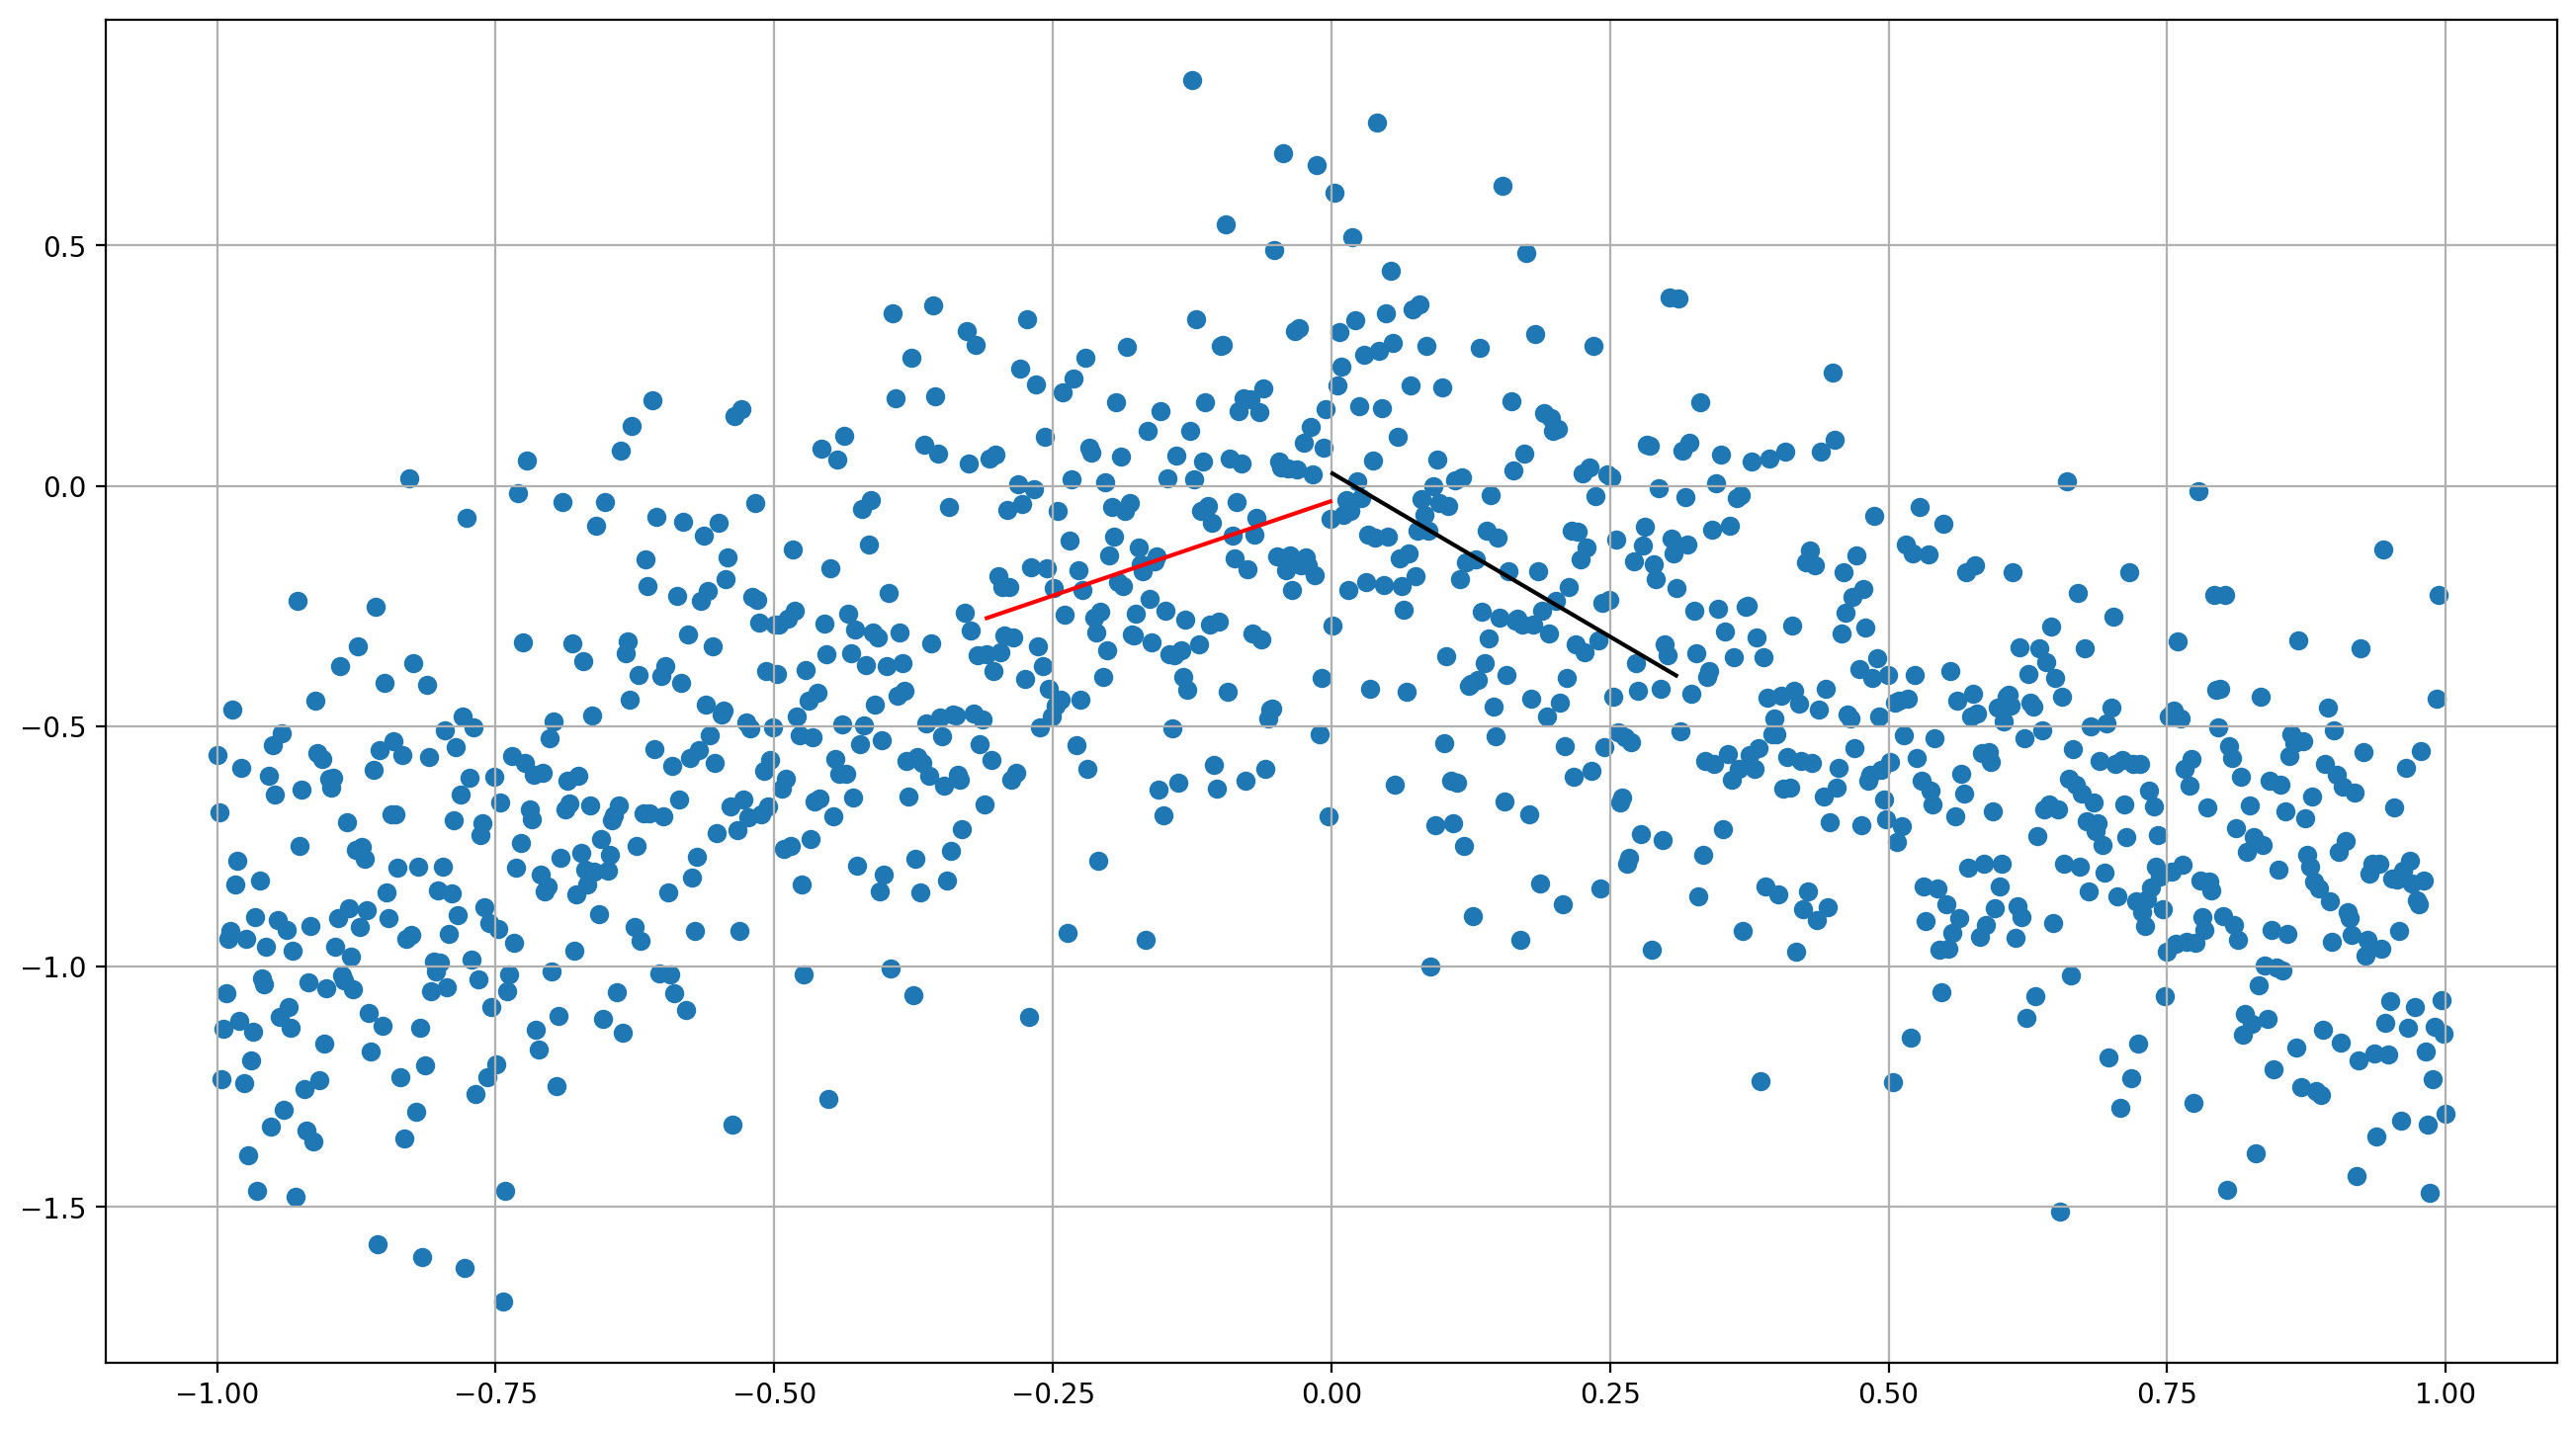

In [15]:
test.scatter_peakreg_plot(0, estimation_mode=False)

In [5]:
test2 = Peak_Valley_Simu()
test2.generate_data(n=500, region=1, intercept=0, left_slope=-0.5, right_slope=-1, error_term=0.3)
result2 = test2.auto_peakzone_detection(x_coordinate=0)
print(result2)
print("left regression mse resid:", result2["left regression"].mse_resid, "right regression mse resid:", result2["right regression"].mse_resid)
print("beta_left:", test2.beta_left, "beta_right:", test2.beta_right)

{'fitting range': 1.01, 'iteration number': 100, 'left regression': <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001C892A8C700>, 'right regression': <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001C892A8C6A0>, 'z_left': 12.297057873991573, 'z_right': 20.220559140914084, 'left_Sxx': 41.74995816637456, 'right_Sxx': 41.74995816637466}
left regression mse resid: 0.0920379810417539 right regression mse resid: 0.08730093947607546
beta_left: -0.5 beta_right: -1


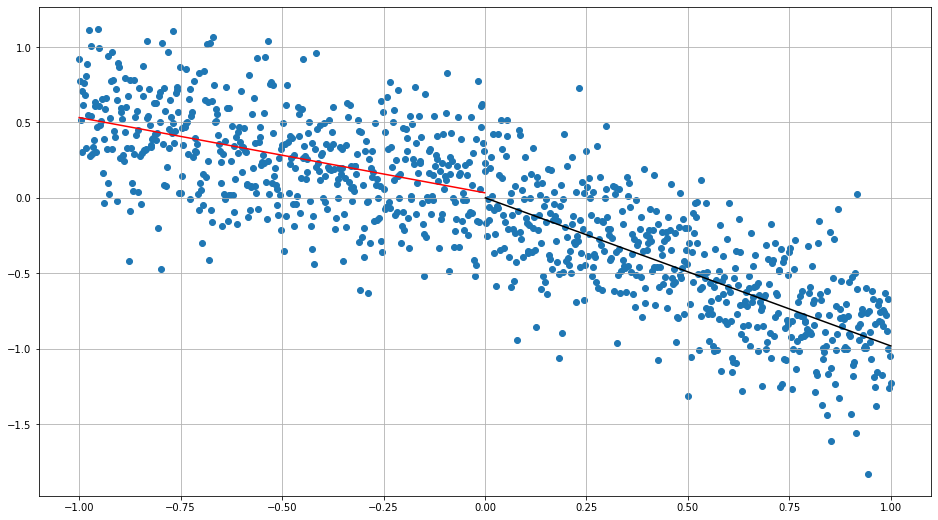

In [6]:
test2.scatter_peakreg_plot(0, estimation_mode=False)

In [7]:
test3 = Peak_Valley_Simu()
result3 = test3.simu_probability(left_slope=0, right_slope=-1)
print(result3["non regularized left Z"][result3["left index"]].shape[0]/1000, result3["non regularized right Z"][result3["right index"]].shape[0]/1000)

0.038 1.0


In [8]:
np.intersect1d(result3["left index"][0], result3["right index"][0]).shape

(38,)

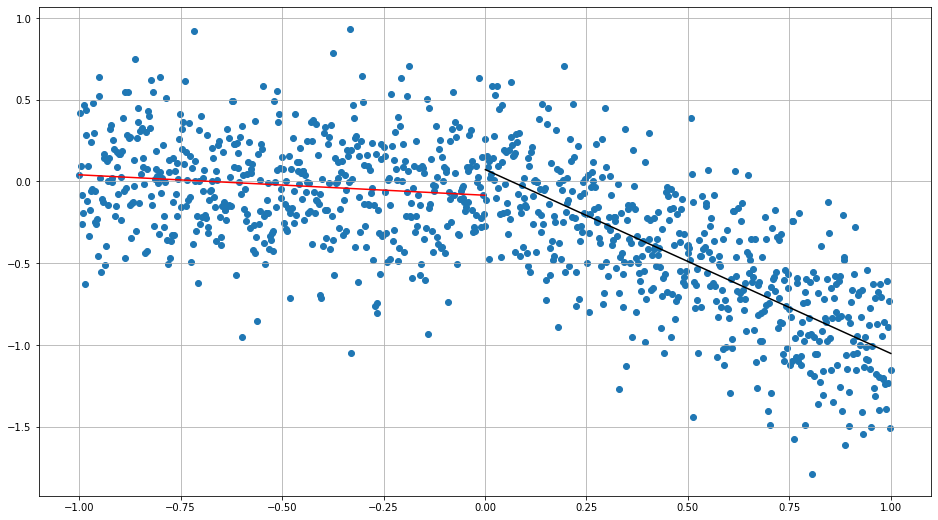

In [9]:
test3.scatter_peakreg_plot(0, estimation_mode=False)

In [10]:
test4 = Peak_Valley_Simu()
result4 = test4.simu_probability(left_slope=0.5, right_slope=-0.5)
print(result4["non regularized left Z"][result4["left index"]].shape[0])

1000


In [11]:
np.intersect1d(result4["left index"][0], result4["right index"][0]).shape

(1000,)

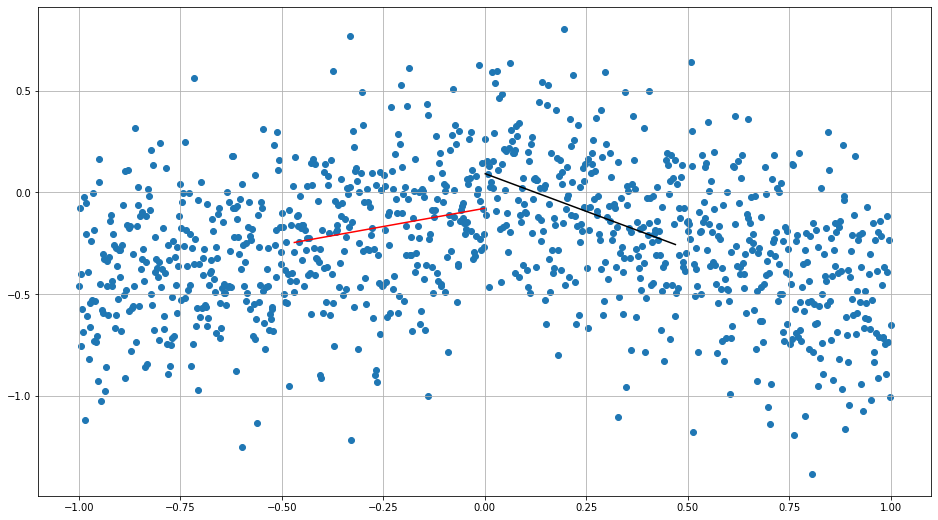

In [12]:
test4.scatter_peakreg_plot(0, estimation_mode=False)